# Group member: LEE ZONG KANG, CHIA JUN XIAN EDMUND, DYLAN LOO YONG-QING

# Course Project: An Arbitrage-Free Smile Interpolator
*Project report should be submitted as a Jupyter notebook (.ipynb). Each project group should have 1 to 3 members. The report should be written based on this notebook. Please make your formulas and code, test results, observations, intermediate results, improvements made/suggested (optional), and conclusions clear.*

#### Objectives
  - Implement an arbitrage free smile interpolator SmileAF.
  - Use the arbitrage free smile interpolator to construct local volatility model
  - Use PDE with local volatility model to price a given set of European options (strike in delta $\times$ maturity)
  - Compare the price errors of arbitrage-free smile interpolator and the cubic spline smile interpolator
  - Open questions for bonus points: improve the algorithms in terms of precision and efficiency (smile interpolation, implied vol, local vol, PDE, calibration report). One area to consider for improvement is the construction of the tails (wings).

##### Smile Arbitrage
1. European call prices are monotonically decreasing with respect to the strike:

    \begin{align}
    C(S_0, K_1, T, \sigma(K_1), r, q) \geq C(S_0, K_2, T, \sigma(K_2), r, q) ~\text{for}~K_1 < K_2
    \end{align}


2. The European call price as a function of strike has to be convex every where: for any three points $K_1 < K_2 < K_3$

    \begin{align*}
    \frac{C(K_2) - C(K_1) } {K_2 - K_1} < \frac{C(K_3) - C(K_2) } {K_3 - K_2}
    \end{align*}

    or

    \begin{align}
    C(K_2)  < C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1}  \tag{2}
    \end{align}

    This is also equivalent to "butterfly price has to be non-negative".

##### When Could Smile Arbitrage Happen?

The undiscounted call price is the expectation of payoff under risk neutral measure

\begin{align*}
C(K) = E[\max(S-K, 0)]
\end{align*}

And expectation is an integral over the probability density function $p(s)$

\begin{align*}
C(K) = \int_{K}^{+\infty} (s-K) p(s) ds
\end{align*}

The 1st non-arbitrage condition translates to

\begin{align*}
& C(K_1) - C(K_2) = \left[ \int_{K_1}^{K_2} (s-K_1) p(s) ds  + \int_{K_2}^{+\infty} (K_2-K_1) p(s) ds \right]
\end{align*}

which is positive by definition if $K_2 > K_1$.

The 2nd non-arbitrage condition translates to

\begin{align*}
& C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1} - C(K_2) \\
= & \frac{K_3-K_2} {K_3 - K_1} \int_{K_1}^{K_2} (s-K_1) p(s) ds + \frac{K_2 - K_1} {K_3 - K_1} \int_{K_2}^{K_3} (K_3 - s) p(s) ds
\end{align*}

which is also positive by definition if $K_3 > K_2 > K_1$.

So, when could smile arbitrage happen? **When the probability density does not exist**. If we can start with valid probability density function $p(s)$, arbitrage-freeness is guaranteed by construction.


#### Arbitrage Free Smile (Based on [Fengler 2009])

- We consider smile construction for a given expiry $T$.
- Start with $N$ discrete sample strike points

    \begin{align*}
    \vec{k} = [k_1, k_2, \ldots, k_{N}]^{\top}
    \end{align*}

- Try to solve for undiscounted call prices for these $N$ sample points

    \begin{align*}
    \vec{c} = [c_1, c_2, \ldots, c_N]^{\top}
    \end{align*}

- For the undiscounted call price $C(K)$ for any $K$, we can interpolate using cubic spline over the sample points $(k_i, c_i)$. (Note that we are using cubic spline to interpolate the prices, not volatility)

- The second derivative of call price with respect to strike is the probability density function:

\begin{align*}
    \frac{d C}{d K} & =  d \frac{\int_K^{\infty} Sp(S) dS}{dK} - d \frac{K\int_K^{\infty} p(S) dS}{dK} = -Kp(K) - \left( \int_K^{\infty} p(S) dS - K p(K)\right) = -\int_K^{\infty} p(S) dS \\
    \frac{d^2 C}{d K^2} & = p(K)
\end{align*}

  So $c_i''$ is probability density function at $k_i$, we denote it as $p_i$

- Second derivatives in cubic spline interpolation form line segments. Cubic spline on $C(K)$, means linearly interpolate on probability density. If $p_i$ are all positive, the whole pdf is positive by construction --- **no smile arbitrage**.

- For tails --- call prices are almost linear if strike is very far away from spot, we can use **natural cubic spline**: $p_1 = p_N = 0$.

- Our problem is to solve for $[c_1, c_2, \ldots, c_{N}, p_2, \ldots, p_{N-1}]$

#### Inputs to our problem

Same as our Cubic Spline smile interpolator, we have the input marks to start with to construct the Arb-Free(AF) smile interpolator:

 - **Marks**:  strike to volatility pairs, denote as $(\hat k_j, \sigma_j)$, for $j \in [1, 2, \ldots, M]$. In our case, $M=5$.

We would like to match the marks exactly. And we cannot directly construct a cubic spline using the $M$ points --- too coarse and distribution is not realistic.

#### Problem Definition
- We use $N = 50$ sample points, ranging from $[k_1 = S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T - 5 \sigma_{ATM} \sqrt{T}}, k_N = S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T + 5 \sigma_{ATM} \sqrt{T} }]$, i.e., $\pm 5$ standard deviation based on $\sigma_{ATM}$.
- $\sigma_{ATM}$ is implied volatility of the middle point of the input marks.
- We also assume the strike of the middle point of the input marks is the forward --- ATM forward convention.
- The sample points are equally spaced, denote the length of the segment $u = \frac{k_N - k_1}{N-1}$
- We would like the call prices to be as smooth as possible --- minimize the change of the slopes
- We want to match exactly the $M$ input marks.
- This is a constrained optimization problem.

 **Constraints**
 - Cubic spline interpolation imposes the constraints that the left and right first derivative of a point have to match, it can be derived by matching the first  derivative of the left and right segments for point $i$ we have the condition

\begin{align*}
   c_{i+1} + c_{i-1} - 2 c_{i} = (\frac23 p_i + \frac16 p_{i+1} + \frac16 p_{i-1}) u^2
\end{align*}

   The cubic spline constraints translate to the linear system

\begin{align*} 
\underbrace{\begin{pmatrix}
   1 & -2 & 1 & 0 & \ldots & 0 \\
   0 & 1 & -2 & 1 & \ddots & \vdots \\
   \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
   0 & \ldots & 0 & 1 & -2 & 1
   \end{pmatrix}}_{\vec{Q}_{(N-2) \times N}}
   \begin{pmatrix}
   c_1 \\
   c_2 \\
   \vdots \\
   c_N
   \end{pmatrix} =
   \underbrace{u^2
   \begin{pmatrix}
   \frac23 & \frac16 & 0 & \ldots & 0 \\
   \frac16 & \frac23 & \frac16 & \ddots & \vdots \\
   0 & \ddots & \ddots & \ddots & 0 \\
   \vdots & \ddots & \frac 1 6 & \frac23 & \frac16 \\
   0 & \ldots & 0 & \frac 1 6 &  \frac23
   \end{pmatrix}}_{\vec{R}_{(N-2) \times (N-2)}}
   \begin{pmatrix}
   p_2 \\
   p_3 \\
   \vdots \\
   p_{N-1}
   \end{pmatrix}
\end{align*}

   If we define
\begin{align*}
   \vec{x} =
   \begin{pmatrix}
   \vec{c}^{\top} \\
   \vec{p}^{\top} \\
   \end{pmatrix}, ~~~
   \vec{A} = (\vec{Q}, -\vec{R})
\end{align*}

   we can represent the constraint as:
\begin{align*}
   \vec{Ax} = \vec{0}        ~~~\textbf{--- Constraint 1}
\end{align*}

 - The call prices at the input marks $\hat k_j, j \in [1, 2, \ldots, M]$ can be represented by cubic spline interpolation
\begin{align*}
   C(\hat k_j) =  a c_i + b c_{i+1} + \frac{(a^3 - a)u^2}6 p_i + \frac{(b^3-b) u^2}6 p_{i+1}   ~~~\textbf{--- Constraint 2}
\end{align*}

   where

\begin{align*}
   a = \frac{k_{i+1} - \hat k_j}{u},~~~b = 1-a
\end{align*}

   and $[k_i, k_{i+1}]$ here represents the segment that $\hat k_j$ falls in.

 - $p_i$ are densities, so

\begin{align*}
    p_i > 0 ~~~\textbf{--- Constraint 3}
\end{align*}

 - Integrating the density function we should get 1.0 (recall that density function are linearly interpolated)

\begin{align*}
    u \sum p_i = 1.0 ~~~\textbf{--- Constraint 4}
\end{align*}

 - Natural cubic spline, $p_1$ and $p_N$ are zero, so we could solve directly $c_1$ and $c_N$

    \begin{align*}
    c_1 = Se^{(r_d - r_f)T} - k_1, ~~~c_N = 0  ~~~\textbf{--- Constraint 5}
    \end{align*}

 - Call prices are monotonically decreasing:

    \begin{align*}
    c_{i+1} - c_{i} \leq 0 ~~~\text{for}~i \in \{1, 2, \ldots, N-1\}  ~~~\textbf{--- Constraint 6}
    \end{align*}


 **Objective Function**

 - Fill the rest of the DOF using objective function (soft constraints)

 - [Fengler 2009] tried minimizing the below to achieve smoothness on $p$:

    \begin{align*}
    \int_{k_1}^{k_N} p(S)^2 dS = \text{constant} \times \vec{p}^{\top} \vec{R} \vec{p}
    \end{align*}

    Using $\vec{x}$ as variable and define

    \begin{align*}
    \vec{H}_{(2N-2) \times (2N-2)} =
    \begin{pmatrix}
    \vec{0} & \vec{0} \\
    \vec{0} & \vec{R}_{(N-2) \times (N-2)}
    \end{pmatrix}
    \end{align*}

    the problem becomes minimizing

    \begin{align*}
    \vec{x}^\top \vec{H} \vec{x}
    \end{align*}

**Problem Formulation**

We can formulate our problem as
\begin{align*}
    \min~~~\vec{x}^\top \vec{H} \vec{x}
\end{align*}
 subject to constraints 1 to 5.
 - All the constraints are linear function of $\vec{x}$
 - Our objective function is quadratic and the matrix $\vec{H}$ is positive semi-definite
 - Global solution exists, and (relatively) efficient to solve

**Tips**
 - To solve the quadratic programming problem, we can use the CVXOPT package:
   - http://cvxopt.org/examples/tutorial/qp.html
   - https://buildmedia.readthedocs.org/media/pdf/cvxopt/dev/cvxopt.pdf
 - Write down the exact formulas using the same symbols used by CVXOPT QP problem's documentation in the above docs, then translate them into code. This will make debugging easier.
 - To check whether solver's result makes sense, examine if the constraints are satisified, and if the call prices are smooth and match the input.
 - If test run takes too long, reduce the number of grid points in PDE pricer, or skip the calibration report and inspect the volatility surface first.
 - It might be easier to plot implied vol, call prices, PDF, and the marks to check the result.
 - use bisect.bisect_left to find the bucket $\hat{k}$ belongs to (https://docs.python.org/3/library/bisect.html)

**References**

[Fengler 2009] Arbitrage-free smoothing of the implied volatility surface, Quantitative Finance, 2009

***
### Implementation

Below are some building blocks for the project. You contribution should be in SmileAF class.
You can modify any other classes or methods. If you do so, please describe your modification in the project report.

In [1]:
import math
from enum import IntEnum
from scipy import optimize
import bisect
from scipy.interpolate import CubicSpline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import matplotlib as mpl

from numba import njit, prange
from numba.experimental import jitclass
from numba import int8, float64
from numba.types import string

from cvxopt import solvers, matrix

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 24
mpl.rcParams["figure.figsize"] = [30, 15]

In [2]:
class PayoffType(IntEnum):
    Call = 0
    Put = 1


@njit
def cnorm(x: float) -> float:
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0


@njit
def fwdDelta(fwd: float, stdev: float, strike: float, payoffType: PayoffType) -> float:
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return -cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)


# solve for the K such that Delta(S, T, K, vol) = delta
def strikeFromDelta(
    S: float,
    r: float,
    q: float,
    T: float,
    vol: float,
    delta: float,
    payoffType: PayoffType,
) -> float:
    fwd = S * math.exp((r - q) * T)
    if payoffType == PayoffType.Put:
        delta = -delta
    f = lambda K: (fwdDelta(fwd, vol * math.sqrt(T), K, payoffType) - delta)
    a, b = 0.0001, 10000
    return optimize.brentq(f, a, b)


class ImpliedVol:
    def __init__(self, ts: float, smiles, ds: list):
        self.ts = ts
        self.smiles = smiles
        self.ds = ds

    # linear interpolation in variance, along the strike line
    def Vol(self, t: float, k: float, i: int, j: int) -> float:
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k, self.ds[i], self.ts[j])
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k, self.ds[i], self.ts[j])
        else:  # in between two brackets
            prevVol, prevT = (
                self.smiles[pos - 1].Vol(k, self.ds[i], self.ts[j]),
                self.ts[pos - 1],
            )
            nextVol, nextT = (
                self.smiles[pos].Vol(k, self.ds[i], self.ts[j]),
                self.ts[pos],
            )
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return math.sqrt((w * prevVar + (1 - w) * nextVar) / t)
        return

    def dVoldK(self, t: float, k: float, i: int, j: int) -> float:
        return (self.Vol(t, k + 0.001, i, j) - self.Vol(t, k - 0.001, i, j)) / 0.002

    def dVoldT(self, t: float, k: float, i: int, j: int) -> float:
        return (self.Vol(t + 0.005, k, i, j) - self.Vol(t, k, i, j)) / 0.005

    def dVol2dK2(self, t: float, k: float, i: int, j: int) -> float:
        return (
            self.Vol(t, k + 0.001, i, j)
            + self.Vol(t, k - 0.001, i, j)
            - 2 * self.Vol(t, k, i, j)
        ) / 0.000001


class LocalVol:
    def __init__(self, iv: ImpliedVol, S0: float, rd: float, rf: float, i: int, j: int):
        self.iv = iv
        self.S0 = S0
        self.rd = rd
        self.rf = rf
        self.i = i
        self.j = j

    def LV(self, t: float, s: float) -> float:
        if t < 1e-6:
            return self.iv.Vol(t, s, self.i, self.j)
        imp = self.iv.Vol(t, s, self.i, self.j)
        dvdk = self.iv.dVoldK(t, s, self.i, self.j)
        dvdt = self.iv.dVoldT(t, s, self.i, self.j)
        d2vdk2 = self.iv.dVol2dK2(t, s, self.i, self.j)
        d1 = (
            (math.log(self.S0 / s) + (self.rd - self.rf) * t + imp * imp * t / 2)
            / imp
            / math.sqrt(t)
        )
        numerator = (
            imp * imp
            + 2 * t * imp * dvdt
            + 2 * (self.rd - self.rf) * s * t * imp * dvdk
        )
        denominator = (1 + s * d1 * math.sqrt(t) * dvdk) ** 2 + s * s * t * imp * (
            d2vdk2 - d1 * math.sqrt(t) * dvdk * dvdk
        )
        localvar = min(max(numerator / denominator, 1e-8), 1.0)
        if numerator < 0:  # floor local volatility
            localvar = 1e-8
        if denominator < 0:  # cap local volatility
            localvar = 1.0
        return math.sqrt(localvar)


spec_option = [
    ("assetName", string),
    ("expiry", float64),
    ("strike", float64),
    ("payoffType", int8),
]


@jitclass(spec_option)
class EuropeanOption:
    def __init__(self, assetName: str, expiry: float, strike: float, payoffType: int):
        self.assetName = assetName
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType

    def payoff(self, S: float) -> float:
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)

    def valueAtNode(self, t: float, S: float, continuation: float) -> float:
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation


# Black-Scholes analytic pricer
@njit
def bsPrice(
    S: float,
    r: float,
    q: float,
    vol: float,
    T: float,
    strike: float,
    payoffType: PayoffType,
) -> float:
    fwd = S * math.exp((r - q) * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    else:
        raise Exception("not supported payoff type", payoffType)


# PDE pricer with local volatility
def compute_lv(
    S0: float, r: float, q: float, lv: LocalVol, NX: int, NT: int, trade: EuropeanOption
) -> [np.ndarray, np.ndarray]:
    mu = r - q
    T = trade.expiry
    X0 = math.log(S0)
    vol0 = lv.LV(0, S0)
    srange = 5 * vol0 * math.sqrt(T)
    maxX = X0 + (mu - vol0 * vol0 * 0.5) * T + srange
    minX = X0 - (mu - vol0 * vol0 * 0.5) * T - srange
    dt = T / (NT - 1)
    dx = (maxX - minX) / (NX - 1)
    # set up spot grid
    minX = X0 - (mu - vol0 * vol0 * 0.5) * T - srange
    xGrid = np.array([minX + i * dx for i in range(NX)])
    vol_arr = np.zeros((NT, NX - 1))
    for j in range(1, NT):
        for i in range(1, NX - 1):
            vol_arr[j, i] = lv.LV(j * dt, math.exp(xGrid[i]))
    return vol0, vol_arr


@njit
def pdePricerX(
    S0: float,
    r: float,
    q: float,
    vol0: float,
    NX: int,
    NT: int,
    w: float,
    trade: EuropeanOption,
    vol_arr: np.ndarray,
) -> float:
    # set up pde grid
    mu = r - q
    T = trade.expiry
    X0 = math.log(S0)
    srange = 5 * vol0 * math.sqrt(T)
    maxX = X0 + (mu - vol0 * vol0 * 0.5) * T + srange
    minX = X0 - (mu - vol0 * vol0 * 0.5) * T - srange
    dt = T / (NT - 1)
    dx = (maxX - minX) / (NX - 1)
    # set up spot grid
    xGrid = np.array([minX + i * dx for i in range(NX)])
    # initialize the payoff
    ps = np.array([trade.payoff(math.exp(x)) for x in xGrid])
    # backward induction
    for j in prange(1, NT):
        # set up the matrix, for LV we need to update it for each iteration
        M = np.zeros((NX, NX))
        D = np.zeros((NX, NX))
        for i in prange(1, NX - 1):
            vol = vol_arr[j, i]
            M[i, i - 1] = (mu - vol * vol / 2.0) / 2.0 / dx - vol * vol / 2 / dx / dx
            M[i, i] = r + vol * vol / dx / dx
            M[i, i + 1] = -(mu - vol * vol / 2.0) / 2.0 / dx - vol * vol / 2 / dx / dx
            D[i, i] = 1.0
        # the first row and last row depends on the boundary condition
        M[0, 0], M[NX - 1, NX - 1] = 1.0, 1.0
        rhsM = (D - dt * M) * w + (1 - w) * np.identity(NX)
        lhsM = w * np.identity(NX) + (D + dt * M) * (1 - w)
        inv = np.linalg.inv(lhsM)

        ps = rhsM.dot(ps)
        ps[0] = (
            dt * math.exp(-r * j * dt) * trade.payoff(math.exp(xGrid[0]))
        )  # discounted payoff
        ps[NX - 1] = dt * math.exp(-r * j * dt) * trade.payoff(math.exp(xGrid[NX - 1]))
        ps = inv.dot(ps)
    # linear interpolate the price at S0
    return np.interp(X0, xGrid, ps)

Below are the smile interpolators and smile constructor. You need to implement SmileAF. Note that smileFromMarks takes a parameter smileInterpMethod. When it is 'AF', SmileAF is used.

In [3]:
class SmileAF:
    def __init__(self, strikes: float, vols: float, T: float):
        self.atmvol = vols[int(len(vols) / 2)]
        self.fwd = strikes[int(len(strikes) / 2)]
        self.T = T
        self.N = 50
        stdev = self.atmvol * math.sqrt(T)
        kmin = self.fwd * math.exp(-0.5 * stdev * stdev - 5 * stdev)
        kmax = self.fwd * math.exp(-0.5 * stdev * stdev + 5 * stdev)
        u = (kmax - kmin) / (self.N - 1)
        self.ks = [kmin + u * i for i in range(0, self.N)]
        self.cs = np.zeros(self.N)  # undiscounted call option prices
        self.ps = np.zeros(self.N)  # densities
        self.u = u
        # now we need to construct our constrained optimization problem to solve for cs and ps
        # ... YOUR CODE HERE ... to solve for self.cs and self.ps
        # ...
        # QP Notes:
        # Inequality Constraint where Gx <= h
        # Equality Constraint where Ax = b
        # Note x is 50 X 100 where 50 x 50 is cs, 50 x 50 is ps
        # But we ignore the tails for ps hence we build x as 48 X 98

        # Constraint 1 (Equality Constraint): Cubic spline interpolation constraints
        # Q is 48 X 50 matrix
        Q = matrix(
            np.diag([1] * (self.N))
            + np.diag([-2] * (self.N - 1), 1)
            + np.diag([1] * (self.N - 2), 2),
            tc="d",
        )[:-2, :]

        # R is 48 X 48 matrix
        R = (self.u**2) * (
            matrix(
                np.diag([1 / 6] * (self.N - 3), -1)
                + np.diag([2 / 3] * (self.N - 2))
                + np.diag([1 / 6] * (self.N - 3), 1)
            )
        )
        # A is 48 X 98 matrix
        A = matrix([[Q], [-R]], tc="d")

        # A @ x == 0
        A_1 = A
        b_1 = matrix(np.zeros(A_1.size[0]), tc="d")

        # Constraint 2 (Equality Constraint): call price at markd = interpolated call price
        A_2 = np.zeros((len(strikes), 2 * self.N - 2))
        b_2 = np.zeros((len(strikes), 1))

        # for each input mark, compute LHS ans RHS
        for i in range(len(strikes)):
            # interpolated price
            second_term_idx = bisect.bisect_left(self.ks, strikes[i])
            first_term_idx = second_term_idx - 1
            fourth_term_idx = second_term_idx + self.N - 1
            third_term_idx = first_term_idx + self.N - 1

            first_term_coeff = (self.ks[second_term_idx] - strikes[i]) / self.u
            second_term_coeff = 1 - first_term_coeff
            third_term_coeff = (
                (first_term_coeff**3 - first_term_coeff) * self.u * self.u / 6.0
            )
            fourth_term_coeff = (
                (second_term_coeff**3 - second_term_coeff) * self.u * self.u / 6.0
            )

            A_2[i][first_term_idx] = first_term_coeff
            A_2[i][second_term_idx] = second_term_coeff
            A_2[i][third_term_idx] = third_term_coeff
            A_2[i][fourth_term_idx] = fourth_term_coeff

            # call price at input mark (LHS)
            d1 = (
                math.log(self.fwd / strikes[i]) / (vols[i] * np.sqrt(T))
                + (vols[i] * np.sqrt(T)) / 2
            )
            d2 = d1 - (vols[i] * np.sqrt(T))
            c_price = self.fwd * cnorm(d1) - cnorm(d2) * strikes[i]

            b_2[i] = c_price

        A_2 = matrix(A_2, tc="d")
        b_2 = matrix(b_2, tc="d")

        # Constraint 3 (Inequality Constraint): PDF (ps) > 0
        G_1 = np.zeros((self.N - 2, 2 * self.N - 2))
        ps_start = 50  # PS starts from idx 50, remb note cs is 50, ps ignore tail is 48
        for i in range(self.N - 2):
            G_1[i][ps_start] = -1
            ps_start += 1
        G_1 = matrix(G_1, tc="d")
        h_1 = matrix(np.zeros(self.N - 2), tc="d")

        # Constraint 4 (Inequality Constraint): sum of PDF = 1
        A_3 = np.zeros(2 * self.N - 2)
        A_3[self.N :] = (
            self.u
        )  # PS starts from idx 50, remb note cs is 50, ps ignore tail is 48
        A_3 = matrix(A_3, tc="d").T
        b_3 = matrix(1, tc="d")

        # Constraint 5 (Inequality Constraint): solving first and last call price
        # first call price
        A_4 = np.zeros(2 * self.N - 2)
        A_4[0] = 1.0
        A_4 = matrix(A_4, tc="d").T
        b_4 = matrix(self.fwd - kmin, tc="d")

        # last call price
        A_5 = np.zeros(2 * self.N - 2)
        A_5[self.N - 1] = 1.0
        A_5 = matrix(A_5, tc="d").T
        b_5 = matrix(0.0, tc="d")

        # Constraint 6 (Inequality Constraint): monotonically decreasing call price
        G_2 = np.zeros((self.N - 1, 2 * self.N - 2))
        for i in range(self.N - 1):
            G_2[i][i] = -1  # ith callprice
            G_2[i][i + 1] = 1  # i+1th call price
        G_2 = matrix(G_2, tc="d")
        h_2 = matrix(np.zeros(G_2.size[0]), tc="d")

        # Objective Function, minimizing H

        # H is 98 X 98, R is 48 X 48
        H = matrix(np.zeros((2 * self.N - 2, 2 * self.N - 2)), tc="d")
        H[self.N :, self.N :] = R

        objective = matrix(2 * H, tc="d")
        q = matrix(
            np.zeros((2 * self.N - 2, 1)), tc="d"
        )  # no linear function so q is 0

        # joining all Inequality constraints
        G_constraints = matrix([G_1, G_2], tc="d")
        h_constraints = matrix([h_1, h_2], tc="d")

        # joining all equality constraints
        A_constraints = matrix([A_1, A_2, A_3, A_4, A_5], tc="d")
        b_constraints = matrix([b_1, b_2, b_3, b_4, b_5], tc="d")

        # The final cvxopt formulation:
        sol = solvers.qp(
            P=objective,
            q=q,
            G=G_constraints,
            h=h_constraints,
            A=A_constraints,
            b=b_constraints,
        )
        print(sol)

        self.cs = sol["x"][0 : self.N]  # First 50 is call prices
        self.ps = self.ps.reshape(self.N, 1)
        self.ps[1:-1] = sol["x"][
            self.N : 2 * self.N - 2
        ]  # last 48 Probabilities of density, first and last pdf = 0

        print("CALL PRICES: ", np.array(self.cs).flatten())
        print("PDFs: ", np.array(self.ps).flatten())

        # now we obtained cs and ps, we do not interpolate for price for any k and imply the vol,
        # since at the tails the price to vol gradient is too low and is numerically not stable.
        # Instead, we imply the volatilities for all points between put 10 delta and call 10 delta input points
        # then we make the vol flat at the wings by setting the vols at kmin and kmax,
        # we then construct a cubic spline interpolator on the dense set of volatilities so that it's C2
        # and faster then implying volatilities on the fly.
        # note that this treatment of tail is simplified. It could also introduce arbitrage.
        # In practice, the tails should be calibrated to a certain distribution.
        def implyVol(k: float, prc: float, v: float) -> float:
            stdev = v * math.sqrt(self.T)
            d1 = (math.log(self.fwd / k)) / stdev + 0.5 * stdev
            d2 = (math.log(self.fwd / k)) / stdev - 0.5 * stdev
            return self.fwd * cnorm(d1) - k * cnorm(d2) - prc

        khmin = bisect.bisect_left(self.ks, strikes[0])
        khmax = bisect.bisect_right(self.ks, strikes[len(strikes) - 1])
        kks = [0] * ((khmax + 1) - (khmin - 1) + 2)
        vs = [0] * ((khmax + 1) - (khmin - 1) + 2)
        for i in range(khmin - 1, khmax + 1):
            prc = self.Price(self.ks[i])
            f = lambda v: implyVol(self.ks[i], prc, v)
            a, b = 1e-8, 10
            vs[i - (khmin - 1) + 1] = optimize.brentq(f, a, b)
            kks[i - (khmin - 1) + 1] = self.ks[i]
        kks[0] = kmin
        vs[0] = vs[1]
        kks[len(kks) - 1] = kmax
        vs[len(vs) - 1] = vs[len(vs) - 2]

        self.vs = vs

        self.cubicVol = CubicSpline(kks, vs, bc_type="natural", extrapolate=True)
        self.cubicVol_lower = CubicSpline(
            kks, vs, bc_type="not-a-knot", extrapolate=True
        )
        self.cubicVol_upper = CubicSpline(kks, vs, bc_type="clamped", extrapolate=True)

    def Vol(self, k: float, ds: float, ts: float) -> float:
        if (
            k < self.ks[0]
        ):  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vs[0]
        if k > self.ks[-1]:
            return self.vs[-1]
        else:
            if ds < 0.2 and ts >= 0.5:
                return self.cubicVol_lower(k)
            elif ts > 1:
                return self.cubicVol_upper(k)
            else:
                return self.cubicVol(k)

    # undiscounted call price - given cs and ps,
    # we can obtain undiscounted call price for any k via cubic spline interpolation
    def Price(self, k: float) -> float:
        if k <= self.ks[0]:
            return self.fwd - k
        if k >= self.ks[self.N - 1]:
            return 0.0
        pos = bisect.bisect_left(self.ks, k)
        a = (self.ks[pos] - k) / self.u
        b = 1 - a
        c = (a * a * a - a) * self.u * self.u / 6.0
        d = (b * b * b - b) * self.u * self.u / 6.0
        return (
            a * self.cs[pos - 1]
            + b * self.cs[pos]
            + c * self.ps[pos - 1]
            + d * self.ps[pos]
        )


class SmileCubicSpline:
    def __init__(self, strikes: float, vols: float):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes + [1.1 * strikes[-1] - 0.1 * strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1] - vols[-2]) / 10]
        self.cs = CubicSpline(
            strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True
        )

    def Vol(self, k: float, i: int = None, j: int = None) -> float:
        if (
            k < self.strikes[0]
        ):  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)


def smileFromMarks(
    T: float,
    S: float,
    r: float,
    q: float,
    atmvol: float,
    bf25: float,
    rr25: float,
    bf10: float,
    rr10: float,
    smileInterpMethod: str,
) -> SmileAF | SmileCubicSpline:
    c25 = bf25 + atmvol + rr25 / 2
    p25 = bf25 + atmvol - rr25 / 2
    c10 = bf10 + atmvol + rr10 / 2
    p10 = bf10 + atmvol - rr10 / 2

    ks = [
        strikeFromDelta(S, r, q, T, p10, 0.1, PayoffType.Put),
        strikeFromDelta(S, r, q, T, p25, 0.25, PayoffType.Put),
        S * math.exp((r - q) * T),
        strikeFromDelta(S, r, q, T, c25, 0.25, PayoffType.Call),
        strikeFromDelta(S, r, q, T, c10, 0.1, PayoffType.Call),
    ]
    # print(T, ks)
    if smileInterpMethod == "CUBICSPLINE":
        return SmileCubicSpline(ks, [p10, p25, atmvol, c25, c10])
    elif smileInterpMethod == "AF":
        return SmileAF(ks, [p10, p25, atmvol, c25, c10], T)

Below is a calibration report that shows the calibration error of local volatility PDE pricer.

In [4]:
def createTestFlatVol(
    S: float, r: float, q: float, smileInterpMethod: str
) -> ImpliedVol:
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [
        0.155,
        0.1395,
        0.1304,
        0.1280,
        0.1230,
        0.1230,
        0.1265,
        0.1290,
        0.1313,
        0.1318,
        0.1313,
        0.1305,
        0.1295,
    ]
    bf25s = np.zeros(len(atmvols))
    rr25s = np.zeros(len(atmvols))
    bf10s = np.zeros(len(atmvols))
    rr10s = np.zeros(len(atmvols))
    smiles = [
        smileFromMarks(
            pillars[i],
            S,
            r,
            q,
            atmvols[i],
            bf25s[i],
            rr25s[i],
            bf10s[i],
            rr10s[i],
            smileInterpMethod,
        )
        for i in range(len(pillars))
    ]
    return ImpliedVol(pillars, smiles)


def createTestImpliedVol(
    S: float, r: float, q: float, sc: float, smileInterpMethod: str
) -> ImpliedVol:
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [
        0.155,
        0.1395,
        0.1304,
        0.1280,
        0.1230,
        0.1230,
        0.1265,
        0.1290,
        0.1313,
        0.1318,
        0.1313,
        0.1305,
        0.1295,
    ]
    bf25s = [
        0.0016,
        0.0016,
        0.0021,
        0.0028,
        0.0034,
        0.0043,
        0.0055,
        0.0058,
        0.0060,
        0.0055,
        0.0054,
        0.0050,
        0.0045,
        0.0043,
    ]
    rr25s = [
        -0.0065,
        -0.0110,
        -0.0143,
        -0.0180,
        -0.0238,
        -0.0288,
        -0.0331,
        -0.0344,
        -0.0349,
        -0.0340,
        -0.0335,
        -0.0330,
        -0.0330,
    ]
    bf10s = [
        0.0050,
        0.0050,
        0.0067,
        0.0088,
        0.0111,
        0.0144,
        0.0190,
        0.0201,
        0.0204,
        0.0190,
        0.0186,
        0.0172,
        0.0155,
        0.0148,
    ]
    rr10s = [
        -0.0111,
        -0.0187,
        -0.0248,
        -0.0315,
        -0.0439,
        -0.0518,
        -0.0627,
        -0.0652,
        -0.0662,
        -0.0646,
        -0.0636,
        -0.0627,
        -0.0627,
    ]
    smiles = [
        smileFromMarks(
            pillars[i],
            S,
            r,
            q,
            atmvols[i],
            bf25s[i] * sc,
            rr25s[i] * sc,
            bf10s[i] * sc,
            rr10s[i] * sc,
            smileInterpMethod,
        )
        for i in range(len(pillars))
    ]
    return ImpliedVol(
        pillars,
        smiles,
        np.arange(0.1, 1.0, 0.1),
    )


def plotTestImpliedVolSurface(S: float, r: float, q: float, iv: ImpliedVol) -> None:
    tStart, tEnd = 0.02, 5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S * math.exp((r - q) * tEnd)
    kmin = strikeFromDelta(
        S, r, q, tEnd, iv.Vol(tEnd, fwdEnd, 0, 0), 0.1, PayoffType.Put
    )
    kmax = strikeFromDelta(
        S, r, q, tEnd, iv.Vol(tEnd, fwdEnd, 0, 0), 0.1, PayoffType.Call
    )
    ks = np.arange(kmin, kmax, 0.01)
    vs = np.ndarray((len(ts), len(ks)))
    lv = LocalVol(iv, S, r, q, 0, 0)
    lvs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j], 0, 0)
            lvs[i, j] = lv.LV(ts[i], ks[j])
    hf = plt.figure(figsize=(8, 6), dpi=80)
    ha = hf.add_subplot(121, projection="3d")
    hb = hf.add_subplot(122, projection="3d")
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs)
    ha.set_title("implied vol")
    ha.set_xlabel("strike")
    ha.set_ylabel("T")
    hb.plot_surface(X, Y, lvs)
    hb.set_title("local vol")
    hb.set_xlabel("strike")
    hb.set_ylabel("T")
    plt.show()


# the PDE calibration error report takes a implied volatility surface,
# verifies the pricing error of the pde pricer with local volatility surface
def pdeCalibReport(S0: float, r: float, q: float, impliedVol: ImpliedVol) -> None:
    ts = [0.02, 0.04, 0.06, 1 / 12.0, 1 / 6.0, 1 / 4.0, 1 / 2.0, 1, 2, 5]
    ds = np.arange(0.1, 1.0, 0.1)
    # ds = np.arange(0.5, 1.7, 0.1)
    err = np.zeros((len(ds), len(ts)))
    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(ts)))
    ax.set_xlabel("T")
    ax.set_yticks(np.arange(len(ds)))
    ax.set_ylabel("Put Delta")
    ax.set_xticklabels(map(lambda t: round(t, 2), ts))
    ax.set_yticklabels(map(lambda d: round(d, 1), ds))

    # Loop over data dimensions and create text annotations.
    for i in range(len(ds)):
        for j in range(len(ts)):
            # create local vol surface
            lv = LocalVol(impliedVol, S0, r, q, i, j)
            T = ts[j]
            K = strikeFromDelta(
                S0,
                r,
                0,
                T,
                impliedVol.Vol(T, S0 * math.exp(r * T), i, j),
                ds[i],
                PayoffType.Put,
            )
            payoff = PayoffType.Put
            trade = EuropeanOption("ASSET1", T, K, payoff)
            vol = impliedVol.Vol(ts[j], K, i, j)
            bs = bsPrice(S0, r, q, vol, T, K, payoff)
            vol0, vol_arr = compute_lv(
                S0, r, q, lv, max(50, int(50 * T)), max(50, int(50 * T)), trade
            )
            pde = pdePricerX(
                S0,
                r,
                q,
                vol0,
                max(50, int(50 * T)),
                max(50, int(50 * T)),
                0.5,
                trade,
                vol_arr,
            )
            # normalize error in 1 basis point per 1 unit of stock
            err[i, j] = math.fabs(bs - pde) / S0 * 10000
            ax.text(
                j,
                i,
                round(err[i, j], 1),
                ha="center",
                va="center",
                color="w",
                fontsize=24,
            )
    im = ax.imshow(err)
    ax.set_title("Dupire Calibration PV Error Matrix")
    fig.tight_layout()
    plt.show()

We test with no smile case first. In the calibration error report, we are showing the error in basis points -- 0.01% with respect to 1 notional.

In [5]:
S, r, q = 1.25805, 0.01, 0.0

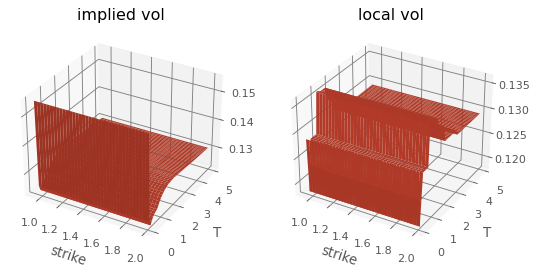

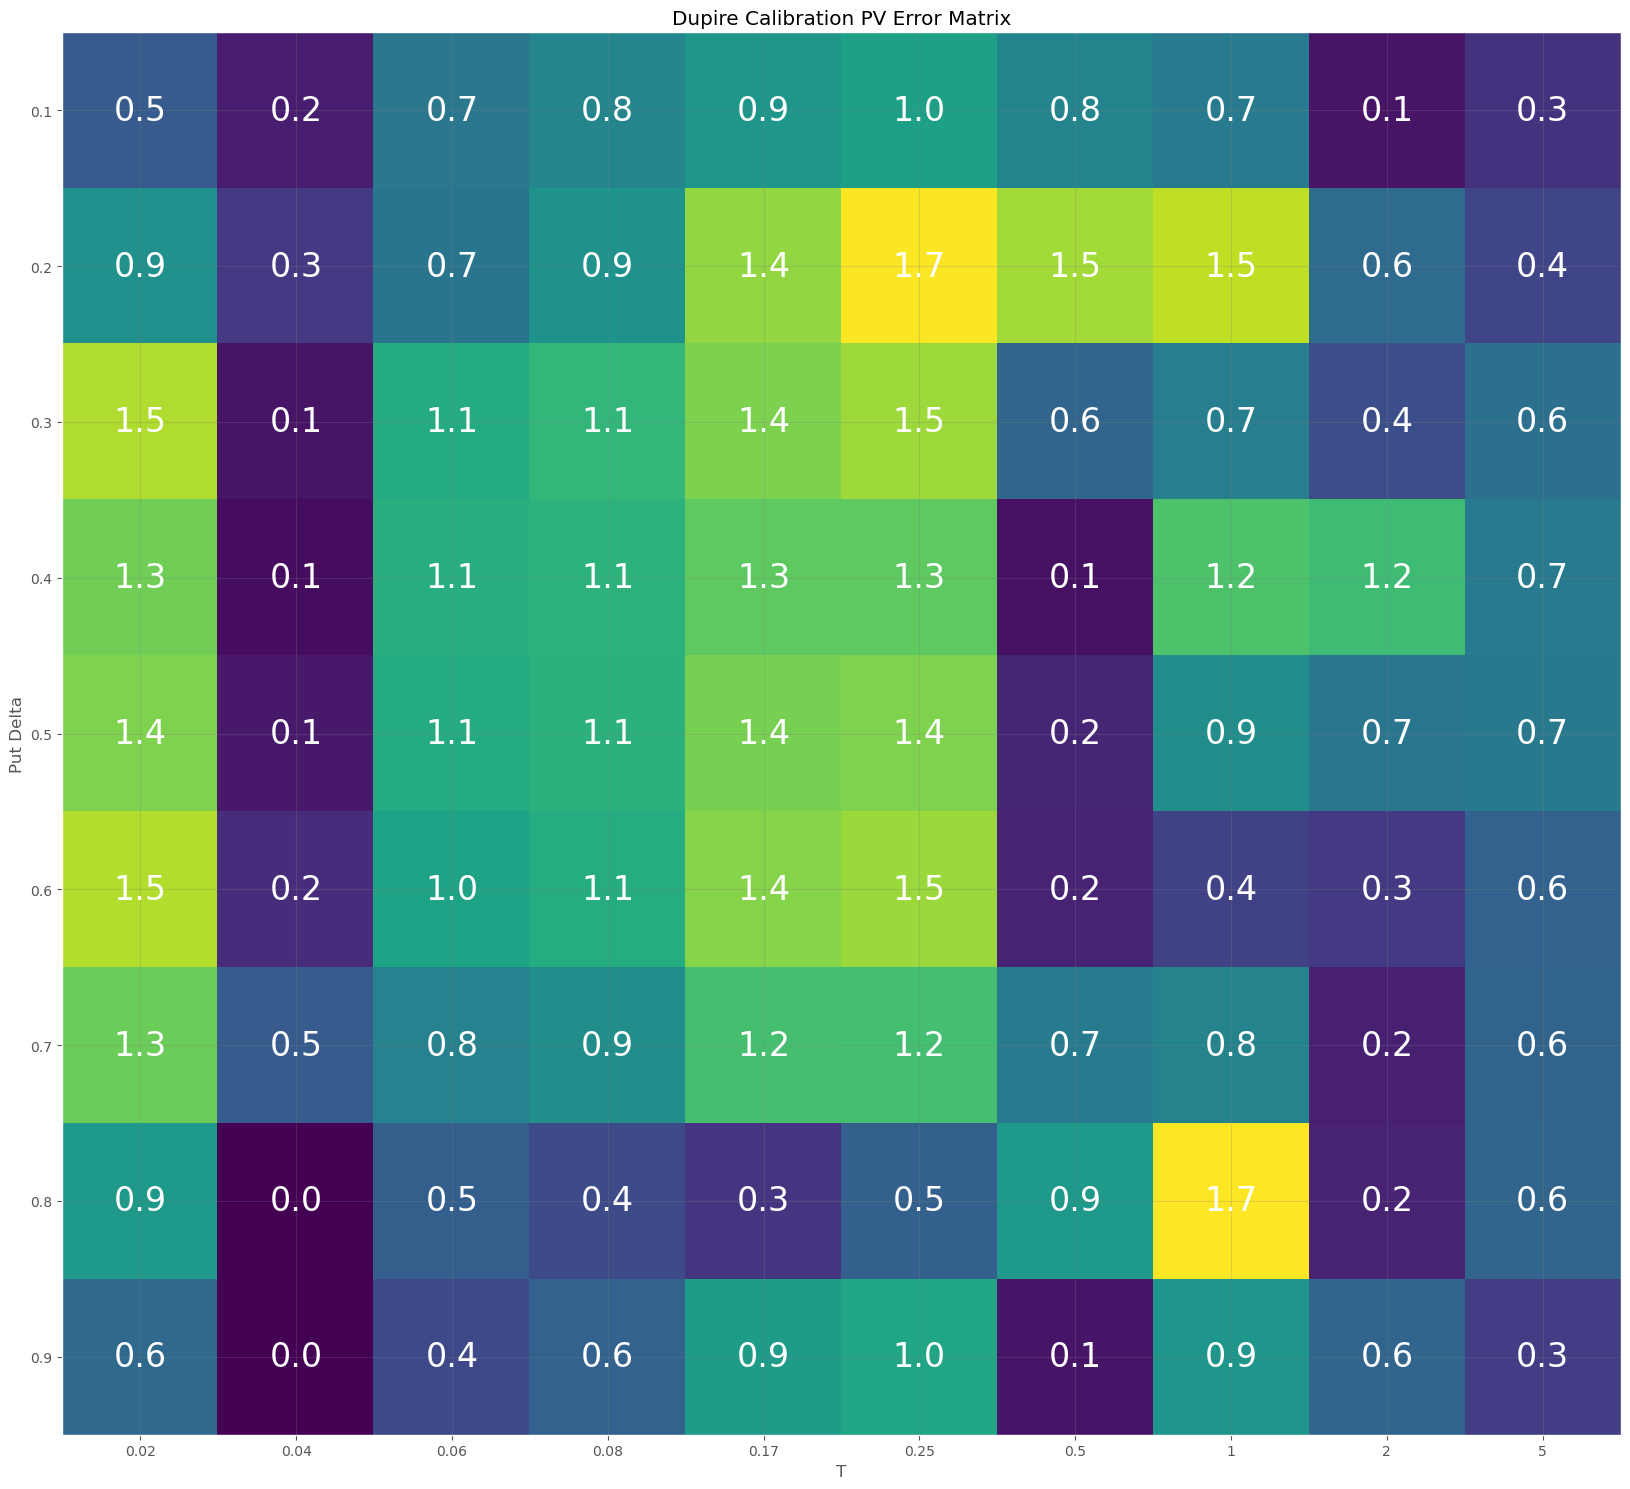

In [6]:
iv = createTestImpliedVol(S, r, q, sc=0.0, smileInterpMethod="CUBICSPLINE")
plotTestImpliedVolSurface(S, r, q, iv)
pdeCalibReport(S, r, q, iv)

Then test smile case with CubicSpline, with a mild smile (tuned by the coeffiicent sc)

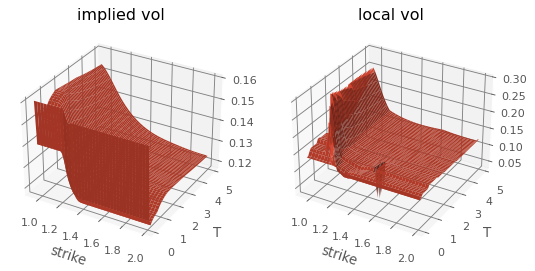

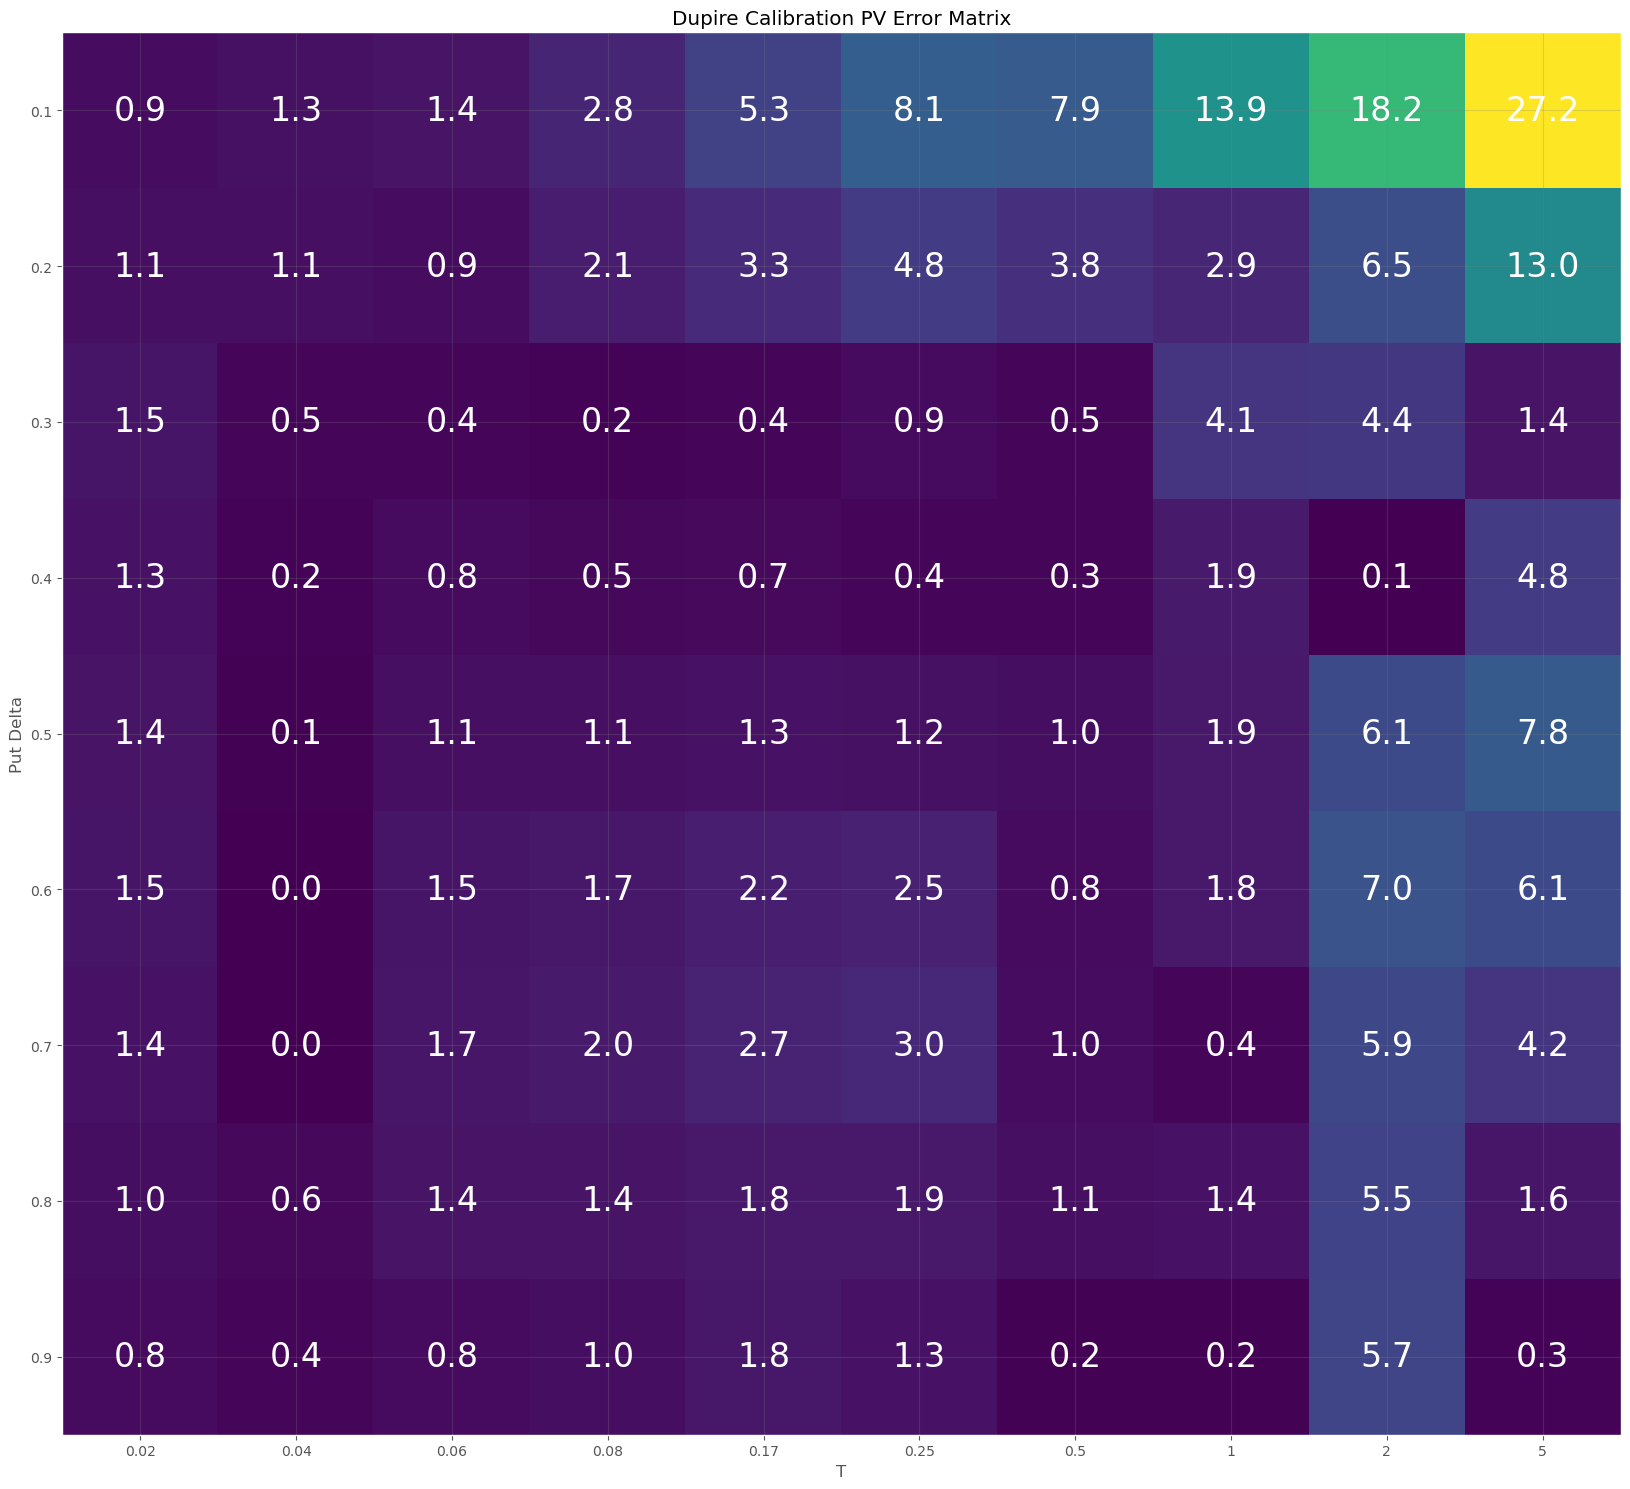

In [7]:
iv = createTestImpliedVol(S, r, q, sc=0.5, smileInterpMethod="CUBICSPLINE")
plotTestImpliedVolSurface(S, r, q, iv)
pdeCalibReport(S, r, q, iv)

Then test smile case with CubicSpline, with a the input smile (sc = 1.0). It can be seen that the short end low strike region has some smile arbitrage. The calibration errors become larger.

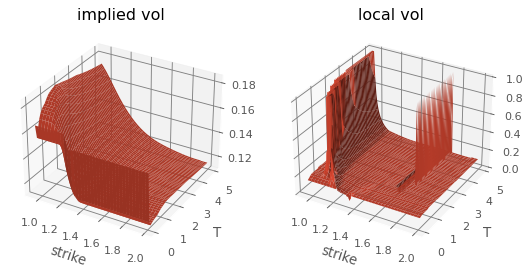

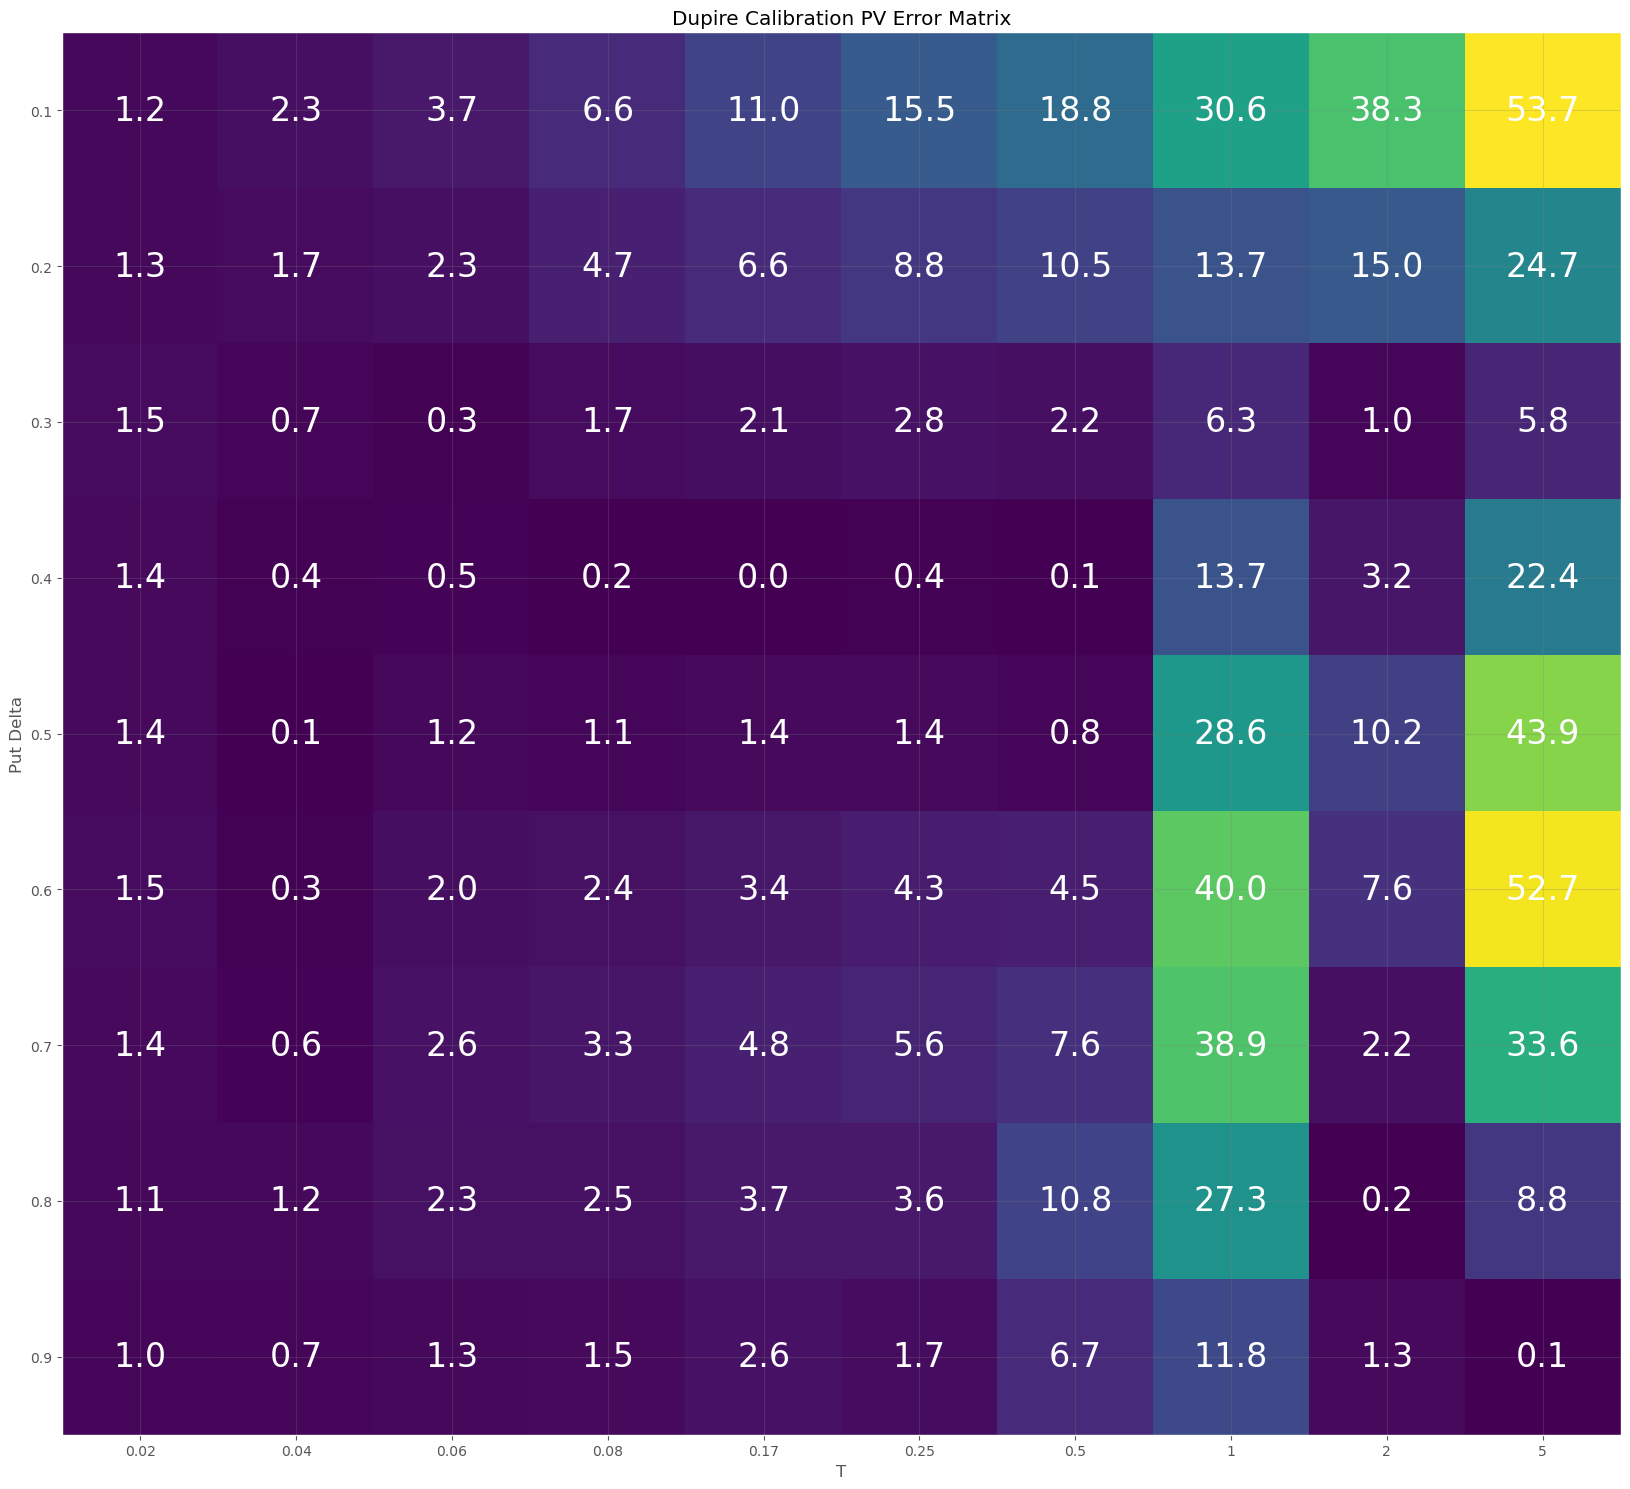

In [8]:
iv = createTestImpliedVol(S, r, q, sc=1.0, smileInterpMethod="CUBICSPLINE")
plotTestImpliedVolSurface(S, r, q, iv)
pdeCalibReport(S, r, q, iv)

***
### Your test cases with SmileAF

     pcost       dcost       gap    pres   dres
 0:  5.7198e-02 -1.0808e+03  4e+03  2e+01  1e+02
 1:  5.7906e-02 -1.6949e+02  3e+02  1e+00  7e+00
 2:  5.9554e-02 -2.3830e+01  3e+01  1e-02  7e-02
 3:  5.9566e-02 -5.5094e-01  6e-01  3e-04  1e-03
 4:  5.9524e-02 -1.2177e-01  2e-01  6e-05  3e-04
 5:  5.9077e-02  3.3330e-02  3e-02  8e-06  5e-05
 6:  5.8502e-02  5.4875e-02  4e-03  9e-07  5e-06
 7:  5.8164e-02  5.7556e-02  6e-04  1e-07  6e-07
 8:  5.8034e-02  5.7915e-02  1e-04  1e-08  8e-08
 9:  5.7995e-02  5.7982e-02  1e-05  1e-09  7e-09
10:  5.7989e-02  5.7989e-02  3e-07  2e-11  9e-11
11:  5.7989e-02  5.7989e-02  4e-09  2e-13  1e-12
Optimal solution found.
{'x': <98x1 matrix, tc='d'>, 'y': <56x1 matrix, tc='d'>, 's': <97x1 matrix, tc='d'>, 'z': <97x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.7617457542962115e-09, 'relative gap': 6.487000475233527e-08, 'primal objective': 0.057988989097122606, 'dual objective': 0.05798898533548807, 'primal infeasibility': 1.8047057954334918e-13, 'dual i

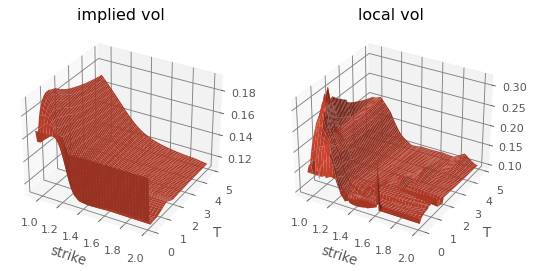

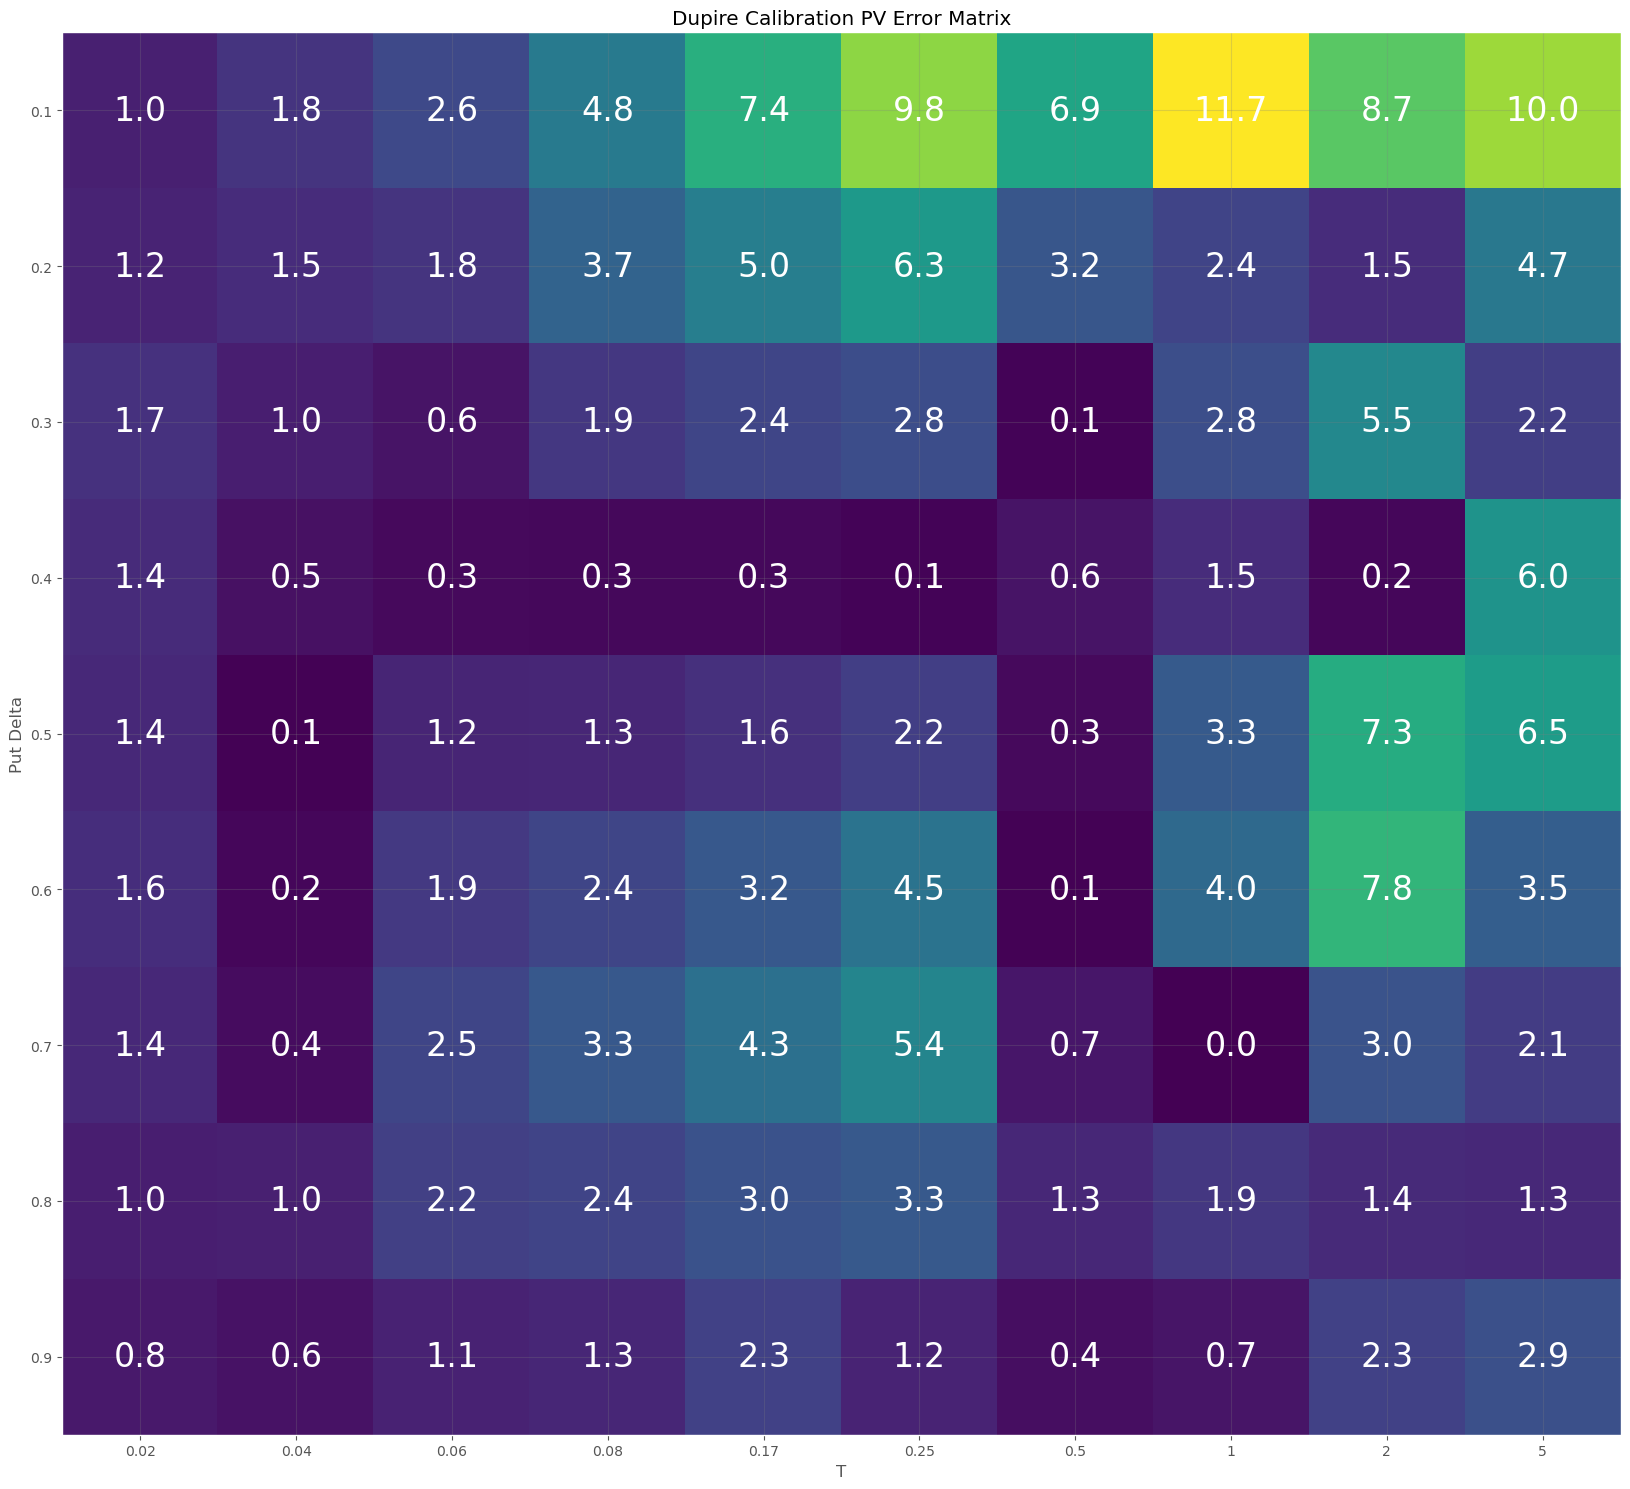

In [9]:
iv = createTestImpliedVol(S, r, q, sc=1.0, smileInterpMethod="AF")
plotTestImpliedVolSurface(S, r, q, iv)
pdeCalibReport(S, r, q, iv)

# Conclusion

#### Compare the price errors of arbitrage-free smile interpolator and the cubic spline smile interpolator

The price error of the arbitrage-free smile interpolator is lower than that of the cubic spline smile interpoator.
This is mainly due to the Arbitrage-Free constraints specified in the minimization problem such that:

1. No mispricing between options: The interpolator will ensure that implied volatilities are chosen such that the resulting option prices do not violate teh calendar and butterfly aribtrage.

2. Non-negative prices: It prevents situations where the interpolated volatility surface might produce negative option prices or unrealistic volatility behavior.

3. Call prices are monotonically decreasing.

#### Open questions for bonus points: improve the algorithms in terms of precision and efficiency (smile interpolation, implied vol, local vol, PDE, calibration report). One area to consider for improvement is the construction of the tails (wings).

In this project, we focused on improving both the precision of the smile interpolation and the efficiency of the calibration process.

**Precision of Smile Interpolation**

1. we noted the default use of the `bc_type = 'clamped'` in the cubicspline interpolator given by the line. 
    ```python
    self.cubicVol = CubicSpline(kks, vs, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)
    ```
    To assess how boundary conditions impact the accuracy of the implied volatility surface, we tested alternatives such as `bc_type = 'not=a-knot'` and `bc_type = 'natural'`. When plotting the Dupire Calibration PV Error Matrix, We found that    
    
    - `bc_type='natural'` yielded lower overall errors 
    
    - `bc_type='not-a-knot'`performed better for put options with longer maturities and lower delta, particularly for maturities greater than 0.5 and delta 0.1. 
    
    - `bc_type = 'clamped'` performed best at long maturities where T > 1
    
    Based on our findings, we used a hybrid approach that combines different boundary conditions depending on the maturity and delta:

    ```python
    self.cubicVol = CubicSpline(kks, vs, bc_type="natural", extrapolate=True)
    self.cubicVol_lower = CubicSpline(
        kks, vs, bc_type="not-a-knot", extrapolate=True
    )
    self.cubicVol_upper = CubicSpline(kks, vs, bc_type="clamped", extrapolate=True)

    def Vol(self, k: float, ds: float, ts: float) -> float:
        if (
            k < self.ks[0]
        ):  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vs[0]
        if k > self.ks[-1]:
            return self.vs[-1]
        else:
            if ds < 0.2 and ts >= 0.5:
                return self.cubicVol_lower(k)
            elif ts > 1:
                return self.cubicVol_upper(k)
            else:
                return self.cubicVol(k)
    ```
Overall, the error was reduced from ~261 to ~238

**Efficency Of Calbiration Report**

The original code had slow performance, making it unsuitable for scaling. We sought ways to speed up the calibration process such as using the Numba library.  

1. Optimizing with Numba

    Numba is a just-in-time (JIT) compiler that translates a subset of Python and NumPy code into fast machine code at runtime, enabling significant performance gains for computationally intensive tasks. It uses LLVM as its backend, allowing the compilation of Python functions to native code, achieving speeds comparable to C compilers. The ```@njit``` decorator in Numba compiles the function into optimized machine code, making it much faster.

    Implementation:
    ```python
    @njit
    def pdePricerX(
        S0: float,
        r: float,
        q: float,
        vol0: float,
        NX: int,
        NT: int,
        w: float,
        trade: EuropeanOption,
        vol_arr: np.ndarray,
    ) -> float:
    ```

2. Parallelization with ```prange```:

    Operations in the calibration process, like the computation of the local volatility in the ```pdePricerX``` method, involve independent iterations over a range of data. This makes the code a good candidate for parallelization.

    Numba’s ```prange``` implements the ability to run loops in parallel. The loops body is scheduled in seperate threads, and they execute in a nopython numba context.

    By using prange, we could divide the work across available cores and speed up the calculations without having to manually manage the parallelization.

    Implementation:
    ```python 
    for j in prange(1, NT):
        # set up the matrix, for LV we need to update it for each iteration
        M = np.zeros((NX, NX))
        D = np.zeros((NX, NX))
        for i in prange(1, NX - 1):
    ```

Result

By applying Numba’s JIT compilation and parallelization with prange, the code now runs approximately 2x faster. This is due to:

 - Reduced overhead from Python’s interpreter: JIT compilation compiles critical functions directly to machine code, bypassing the interpreter and reducing runtime overhead.

 - Parallel execution: The prange function efficiently divides computations across multiple CPU cores, speeding up iterations that are independent of each other.

The optimization significantly improves performance, allowing the calibration process to run faster and be more scalable.